In [1]:
from dotenv import load_dotenv 

load_dotenv() 


True

In [2]:
from langchain_openai import ChatOpenAI 

llm = ChatOpenAI(model='gpt-4o') 


In [4]:
from langchain_core.tools import tool 

@tool 
def add(a: int, b: int) -> int:
    """
    두 숫자를 더합니다.
    """     
    return a + b  

@tool 
def multiply(a: int, b: int) -> int:
    """
    두 숫자를 곱합니다.
    """
    return a * b



In [5]:
from langgraph.prebuilt import ToolNode 

tool_list = [add, multiply] 
llm_with_tools = llm.bind_tools(tool_list) 
tool_node = ToolNode(tool_list) 




In [7]:
multiply.invoke({'a': 1, 'b': 2})

2

In [49]:
from langchain_core.messages import AnyMessage
from typing import Sequence 

messages: Sequence[AnyMessage] = [ ]
messages

[]

In [50]:
ai_message = llm_with_tools.invoke('What is 3 plus 5?')
messages.append(ai_message)
messages    

[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nYyISKM9THhr4vEQF7jNO2wD', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 78, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-022001a6-d8a5-431c-9a2b-1e6cd6531ba9-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_nYyISKM9THhr4vEQF7jNO2wD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 17, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})]

In [51]:
tool_message = tool_node.invoke({'messages': [ai_message]})
# tool_message['messages'][0]
messages.append(tool_message['messages'][0])
messages


[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_nYyISKM9THhr4vEQF7jNO2wD', 'function': {'arguments': '{"a":3,"b":5}', 'name': 'add'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 78, 'total_tokens': 95, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-022001a6-d8a5-431c-9a2b-1e6cd6531ba9-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 5}, 'id': 'call_nYyISKM9THhr4vEQF7jNO2wD', 'type': 'tool_call'}], usage_metadata={'input_tokens': 78, 'output_tokens': 17, 'total_tokens': 95, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}),
 ToolMessage(content=

In [52]:
llm_with_tools.invoke(messages)

AIMessage(content='3과 5를 더하면 8입니다.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 12, 'prompt_tokens': 91, 'total_tokens': 103, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_76544d79cb', 'finish_reason': 'stop', 'logprobs': None}, id='run-c54bb9b1-39ef-428e-98c9-8ca1694dc612-0', usage_metadata={'input_tokens': 91, 'output_tokens': 12, 'total_tokens': 103, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [56]:
from langgraph.graph import MessagesState, StateGraph  

graph_builder = StateGraph(MessagesState) 

In [57]:
def agent(state: MessagesState) -> MessagesState:
    messages = state['messages']  

    response = llm_with_tools.invoke(messages)  
    # print(response)
    return {'messages': [response]}  

In [58]:
from typing import Literal 
from langgraph.graph import END 

def should_continue(state: MessagesState) -> Literal['tools', 'END']:
    messages = state['messages'] 
    last_ai_message = messages[-1] 

    if last_ai_message.tool_calls:
        return 'tools' 

    return END         

In [59]:
graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)

In [60]:
from langgraph.graph import START, END 

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges(
    'agent', 
    should_continue,
    ['tools', END] 
)
graph_builder.add_edge('tools', 'agent')

In [61]:
graph= graph_builder.compile()

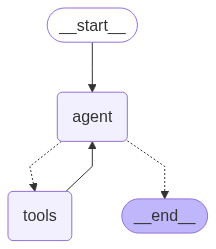

In [62]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [63]:
from langchain_core.messages import HumanMessage

for chunk in graph.stream({'messages': [HumanMessage('3에다 5를 더하고 거기에 8을 곱하면?')]}, stream_mode='values'):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

3에다 5를 더하고 거기에 8을 곱하면?
================================== Ai Message ==================================
Tool Calls:
  add (call_aU3S6wTOpPiY9yC0dhmOGA6j)
 Call ID: call_aU3S6wTOpPiY9yC0dhmOGA6j
  Args:
    a: 3
    b: 5
  multiply (call_FdsaqIylI9ByY55HfjqwfozR)
 Call ID: call_FdsaqIylI9ByY55HfjqwfozR
  Args:
    a: 8
    b: 8
================================= Tool Message =================================
Name: multiply

64
================================== Ai Message ==================================

3에 5를 더하면 8이 되고, 그 결과에 8을 곱하면 64가 됩니다.
